In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"
data_route = "../data/sims/L=21/"


In [3]:
def kth_diag_indices(a, k):
    # negative numbers go below the diagonal, 0 is the main diagonal and positive nums go above
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
# Find index of the closest value
def find_nearest(arr, target):
    idx = np.abs(arr - target).argmin()
    return arr[idx], idx

# Perturbations to the energy

we compared to the exact diagonalization

In [48]:
L_qpc = 21
L = L_qpc + 2
t = 0.3 # dd hopping
Omega = 0.9
J_prime = 1
bond_index = int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  

# create the fermion operator list
bond_index

10

Bond at:  20


<Axes: >

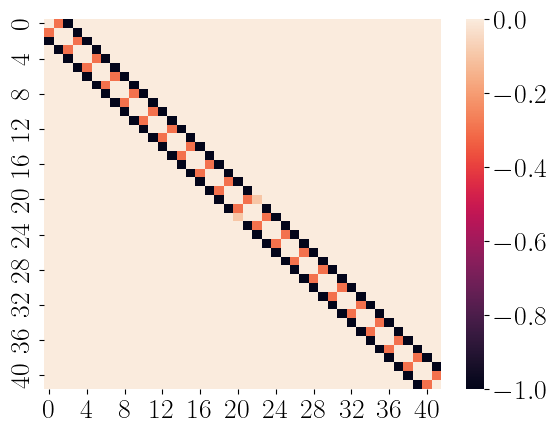

In [49]:
H_matrix = np.zeros((2*L_qpc,2*L_qpc))
# fill in the dd hopping only in odd diagonals
d_indices= kth_diag_indices(H_matrix,1)
H_matrix[d_indices] = -t

# fill in the QPC hopping
d_indices= kth_diag_indices(H_matrix,2)
H_matrix[d_indices] = -J[0]

# when qpc and qubit hop a the same time there is no contribution
d_indices= kth_diag_indices(H_matrix,1)
odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
H_matrix[odd_inds] = 0

Hdeco = H_matrix

# Fill in the interaction at the bond
H_matrix[2*bond_index,2*(bond_index+1)] = H_matrix[2*bond_index,2*(bond_index+1)]+ Omega

# Now the elemets below the diagonal
for i in range(0,2*L_qpc):
    for j in range(i + 1, 2*L_qpc):
        H_matrix[j, i] = H_matrix[i, j]
        Hdeco[j, i] = Hdeco[i, j]

print("Bond at: ", 2*bond_index)
sns.heatmap(H_matrix)

In [50]:
# Calculate the energies and eigenvectors
energies, eigen_vecs = np.linalg.eig(H_matrix)
# normalize
eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)

# calculate the decoupled system analytic eigenenergies (zeroth order correction)
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)
em0 = -2*J[0]*np.cos(k_single_band) - t 
ep0 = -2*J[0]*np.cos(k_single_band) + t 

# find the momenta that we are mostly interested in (far from the edges of the brillouin zone)
_, cut1 = find_nearest(k_single_band, 0.2*np.pi)
_, cut2 = find_nearest(k_single_band, 0.8*np.pi)

np.dot(eigen_vecs[1], eigen_vecs[1])

0.999999999999999

## Separating into bands
Here we expect two bands, however we have to be carefull because **linalg spits the eigenvectors and states all mixed up instead of in neat bands**. So what we have to do is construct a projection operator and apply it to the eigenstates from numpy. Their values will be either 1 or 0 and with that we will be able to sort them into the proper symmetry bands

In [51]:
def sort_by_projection(energy_list,eigen_list, Proj):
    # sorts the eigenvectors from numpy diagonalize into bands by their projection onto Proj
    P_elements = []
    # separate into bands accordin to their projection
    for i in range(0,len(energy_list)):
        # for plus states
        ev = eigen_list[:,i]
        ev_proj = np.matmul(Proj,ev)
        # here we round off to nearest integer only for the separation
        P_elements.append(round(np.dot(np.conj(ev), ev_proj)))
        
    P_elements = np.asarray(P_elements)
    
    # the symmetric states will be those with 1
    idx = np.argwhere(P_elements==1)[:,0]
    energies_p = energy_list[idx]
    states_p = eigen_list[:,idx]
    # sort in order of increasing energy
    sort_idx = np.argsort(energies_p)
    energies_p = energies_p[sort_idx]
    states_p = states_p[:,sort_idx]
    
    # the antisymmetric states will be those with 0
    idx = np.argwhere(P_elements==0)[:,0]
    energies_m = energy_list[idx]
    states_m = eigen_list[:,idx]
    # sort in order of increasing energy
    sort_idx = np.argsort(energies_m)
    energies_m = energies_m[sort_idx]
    states_m = states_m[:,sort_idx]

    return energies_m, states_m, energies_p, states_p

def separate_band(eigen_array, energy_array):
    # since linalg spits out eigenvalues is some weird order se
    # organize them in the proper band corresponding to the qubit states
    band_list = []
    index_list = []
    for target_ in energy_array:
        closest, index_c = find_nearest(eigen_array, target_)
        band_list.append(closest)
        index_list.append(index_c)
    
    return np.asarray(band_list), index_list
    

def get_projection_colors(state_list, Proj):
    # get the colors for the band in staet list
    # acording to the matrix element of the projection Proj
    colors_ = []
    # calculate the colors
    for i in range(0,np.shape(state_list)[1]):
        # for plus states
        ev = state_list[:,i]
        ev_proj = np.matmul(Proj,ev)
        colors_.append(np.dot(np.conj(ev), ev_proj))
        
    return np.asarray(colors_)


In [52]:
def separate_by_proximity(numeric_energy, numeric_states):
    # sorts numeric energy in accordance to the proximity to the two decoupled bands em0 ep0
    sort_idx = np.argsort(numeric_energy)
    sorted_energies = numeric_energy[sort_idx]
    sorted_states = numeric_states[:,sort_idx]

    marker_list = []

    ep_copy = ep0
    em_copy = em0
    
    for i in range(0, len(sorted_energies)):
        # find the closest state in the plus band
        ep_close, p_idx = find_nearest(ep_copy, sorted_energies[i])
        # find the closest state in the minus band
        em_close, m_idx = find_nearest(em_copy, sorted_energies[i])
        
        # get the difference and sort according to which is the smallest
        dif_plus = abs(sorted_energies[i] - ep_close)
        dif_minus = abs(sorted_energies[i] - em_close)

        # accept in the minus band
        if dif_plus>=dif_minus:
            marker_list.append(0)
            # remove to avoid double counting
            # np.delete(ep_copy, p_idx)
        else:
            marker_list.append(1)
            # np.delete(em_copy, m_idx)
            
    marker_list = np.asarray(marker_list)
    
    idx = np.argwhere(marker_list==1)[:,0]
    plus_energies = sorted_energies[idx]
    plus_states = sorted_states[:,idx]

    idx = np.argwhere(marker_list==0)[:,0]
    minus_energies = sorted_energies[idx]
    minus_states = sorted_states[:,idx]

    return minus_energies, minus_states, plus_energies, plus_states, 

In [53]:
def sort_by_overlap(energy_list, eigen_list, P_state):
    # sorts according to the P_state overlatps

    P_elements = []
    # separate into bands accordin to their projection
    for i in range(0,len(energy_list)):
        # for plus states
        ev = eigen_list[:,i]
        ev_proj = np.dot(np.conj(P_state),ev)**2
        P_elements.append(round(ev_proj))
            
    P_elements = np.asarray(P_elements)

    # the symmetric states will be those with 1
    idx = np.argwhere(P_elements==1)[:,0]
    energies_p = energy_list[idx]
    states_p = eigen_list[:,idx]
    # sort in order of increasing energy
    sort_idx = np.argsort(energies_p)
    energies_p = energies_p[sort_idx]
    states_p = states_p[:,sort_idx]
    
    # the antisymmetric states will be those with 0
    idx = np.argwhere(P_elements==0)[:,0]
    energies_m = energy_list[idx]
    states_m = eigen_list[:,idx]
    # sort in order of increasing energy
    sort_idx = np.argsort(energies_m)
    energies_m = energies_m[sort_idx]
    states_m = states_m[:,sort_idx]

    return energies_m, states_m, energies_p, states_p

def get_overlap_colors(state_list, P_state):
    # get the colors for the band in staet list
    # acording to the matrix element of the projection Proj
    colors_ = []
    # calculate the colors
    for i in range(0,np.shape(state_list)[1]):
        # for plus states
        ev = state_list[:,i]
        ev_proj = np.dot(np.conj(P_state),ev)
        colors_.append(ev_proj)
        
    return np.asarray(colors_)

In [54]:
def plot_2_bands(Em_correct, Ep_correct, Energies_m, Energies_p, Colors_m, Colors_p, Figuresize=(13,5)):
    # Em_correct, Ep_correct are the perturbatively corrected energies 
    # Energies_m, Energies_p are the numpy eigenvalues
    fig, ax = plt.subplots(1,2, figsize=Figuresize)

    ax[0].plot(k_single_band, Em_correct, c= "red")
    ax[0].plot(k_single_band, Ep_correct, c= "blue")
    # zoomed in 
    ax[1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    
    # Diagonalized 
    sns.scatterplot(x=k_single_band, y=Energies_p, hue= Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0])
    
    img = sns.scatterplot(x=k_single_band, y=Energies_m, hue= Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0])
    
    # zoomed
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_p[cut1:cut2], hue= Colors_p[cut1:cut2], hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[1])
    
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_m[cut1:cut2], hue= Colors_m[cut1:cut2], hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[1],)

    # Get the scatter object and attach colorbar
    norm = plt.Normalize(c_norm[0], c_norm[1])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])  # Required for ScalarMappable with no mappable object
    plt.colorbar(sm, ax=ax)
    
    # write x axis in units of pi
    ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    
    ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    ax[0].set_xlabel(r"$k$")
    ax[0].set_ylabel(r"$E$")
    ax[1].set_xlabel(r"$k$")
    

### Separating by Projection

In [55]:
# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product


In [56]:
energies_m, states_m, energies_p, states_p = sort_by_projection(energies,eigen_vecs, Psym)

# get the colors for each band 
colors_p = get_projection_colors(states_p, Psym)
colors_m = get_projection_colors(states_m, Psym)

### coloring by trace projection overlap

here we want to remove the momentum mixing that goes on with the perturbations by tracing out over those eigenstates

In [57]:
# get the momentum \otimes + eigenstates for a given k
plus_state = np.sqrt(1/2)*np.asarray([1,1])
vk = np.zeros(L_qpc)

for k in k_single_band:
    # sum over kstates
    vk = vk + np.asarray([np.sqrt(2/(L_qpc+1))*np.sin(j*k) for j in range(1,L_qpc+1)])

# normalize
vk = vk #/np.sqrt(L_qpc)
trace_P = np.kron(vk,plus_state)


In [58]:
tr_energies_m, tr_states_m, tr_energies_p, tr_states_p = sort_by_overlap(energies,eigen_vecs, trace_P)

# tr_colors_p = get_overlap_colors(tr_states_p, trace_P)
# tr_colors_m = get_overlap_colors(tr_states_m, trace_P)

tr_colors_p = get_overlap_colors(states_p, trace_P)
tr_colors_m = get_overlap_colors(states_m, trace_P)

tr_colors_p

array([-0.72478222, -0.18518457, -0.37748821, -0.48445212, -0.38229675,
       -0.61217633,  0.40652444,  0.36957805,  0.44702388,  0.0211641 ,
       -0.50102327, -0.2236783 ,  0.90629393, -0.86902575,  0.09067643,
        0.93782497,  0.18299406,  0.03631213,  0.05780033, -0.01210165,
       -0.02827381])

### Sepparating by proximity

Separating with proximity to decoupled energies: **This will not work because sometimes I have eigenvaleus that are very far away annd they wont get assigned at all. Try this one out:**

https://scicomp.stackexchange.com/questions/10708/sorting-eigenvalues-by-the-dominant-contribution 

In [59]:


# this proximity method was wrong because it was matching the wrong way around

# proximity_m, indices_m = separate_band(energies,em0)
# proximity_p, indices_p = separate_band(energies,ep0)

# get the colors for each band 
# pro_colors_p = get_projection_colors(eigen_vecs[:,indices_p], Psym)
# pro_colors_m = get_projection_colors(eigen_vecs[:,indices_m], Psym)

proximity_m, prox_state_m, proximity_p, prox_state_p = separate_by_proximity(energies, eigen_vecs)

pro_colors_p = get_projection_colors(prox_state_p, Psym)
pro_colors_m = get_projection_colors(prox_state_m, Psym)

### Sorting by eigenstate continuity

As mentioned in https://scicomp.stackexchange.com/questions/10708/sorting-eigenvalues-by-the-dominant-contribution: 

    You'd like to sort eigenvalues/eigenvectors in a way that is continuous as you move through momentum. This highly constrains the sorting - for most k-points, you must sort the eigenvalues to be a close as possible to the eigenvalues from a neighboring k-point. Only at eigenvalue crossings are you allowed to permute the order of bands. Furthermore, in many scenarios crossings don't actually occur - instead, with sufficient resolution, you would see an "avoided crossing", and true continuity of the eigenvalues would require the eigenvalues to stay in increasing order throughout. In the case of avoided crossings, it may still make sense to allow the band assignment to swap, depending on your situation.
    
    One situation where true crossings due occur is if your bands have different symmetry representations, and thus cannot mix. In this case, you can order your eigenvectors first by symmetry sector and then by increasing eigenvalues.
    
    If you cannot use symmetry, then I'd suggest the following strategy:
    
    Pick a initial momentum point, and sort the eigenvectors at that point based on increasing energy. For each additional momentum, match each eigenvector with one at the previous momentum point by finding the maximum overlap. If the momentum spacing is very small, these identifications should only allow changes in order at a level crossing.

Also check out 

https://mathoverflow.net/questions/407738/sorting-energy-bands-in-physics

and 

https://quantumtinkerer.tudelft.nl/blog/connecting-the-dots/

### Comparing the methods

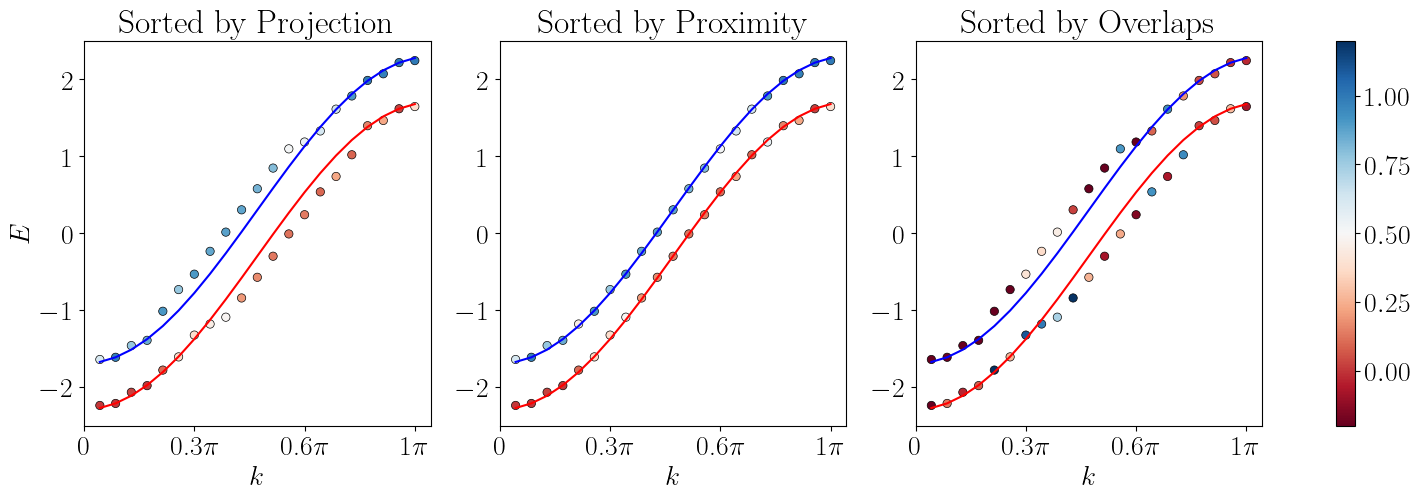

In [60]:
fig, ax = plt.subplots(1,3, figsize=(19,5))

c_norm = (-0.2,1.2)
cmap = "RdBu"
# zeroth order analytic stuff
ax[0].plot(k_single_band, em0, c= "red")
ax[0].plot(k_single_band, ep0, c= "blue")

ax[1].plot(k_single_band, em0, c= "red")
ax[1].plot(k_single_band, ep0, c= "blue")

ax[2].plot(k_single_band, em0, c= "red")
ax[2].plot(k_single_band, ep0, c= "blue")

# projection
sns.scatterplot(x=k_single_band, y=energies_p, hue= colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[0])
sns.scatterplot(x=k_single_band, y=energies_m, hue= colors_m, hue_norm= c_norm, palette=cmap ,
                edgecolor="black", legend=None,ax=ax[0])

# proximity 
sns.scatterplot(x=k_single_band, y=proximity_p, hue= pro_colors_p, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

sns.scatterplot(x=k_single_band, y=proximity_m, hue= pro_colors_m, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

# overlaps
sns.scatterplot(x=k_single_band, y=energies_p, hue= tr_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[2])

img = sns.scatterplot(x=k_single_band, y=energies_m, hue= tr_colors_m, palette=cmap ,
                edgecolor="black", legend=None,ax=ax[2])

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$E$")
ax[0].set_title(r"Sorted by Projection")

ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Proximity")

ax[2].set_xlabel(r"$k$")
ax[2].set_title(r"Sorted by Overlaps")


# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object
plt.colorbar(sm, ax=ax)

# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))


Compare energy gaps wrt the decoiupled case

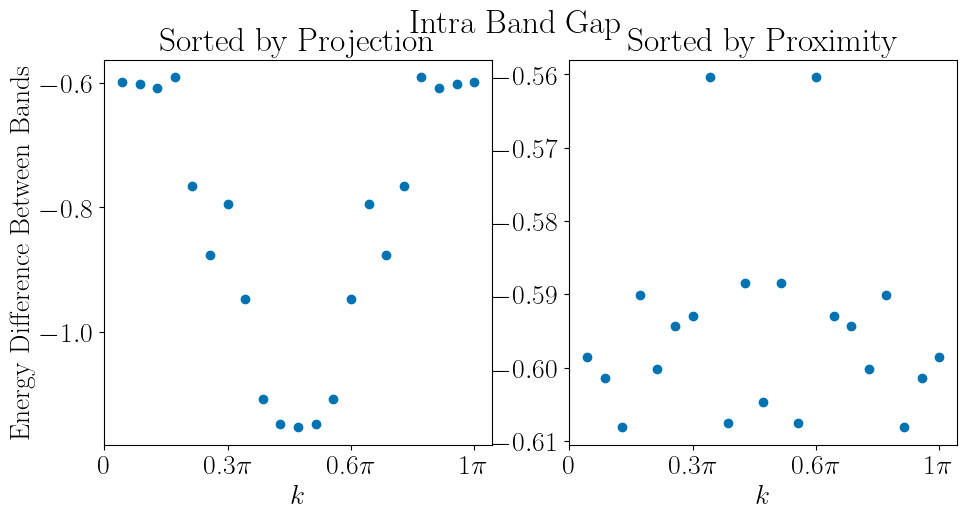

In [61]:
fig, ax = plt.subplots(1,2, figsize=(11,5))

plt.suptitle("Intra Band Gap")

ax[0].scatter(k_single_band, energies_m-energies_p)
ax[1].scatter(k_single_band, proximity_m-proximity_p)

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Energy Difference Between Bands")
ax[0].set_title(r"Sorted by Projection")

ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Proximity")


# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

Text(0.5, 0.98, 'Inter Band Gap')

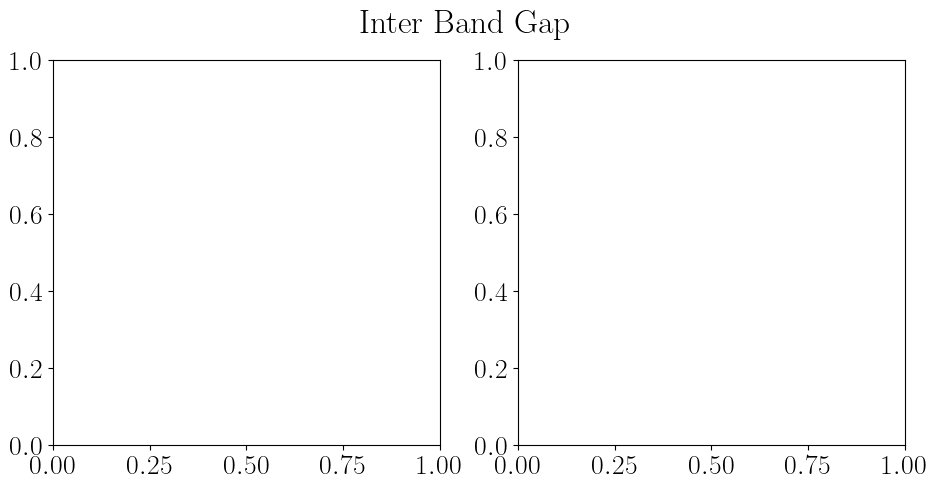

In [62]:
fig, ax = plt.subplots(1,2, figsize=(11,5))

plt.suptitle("Inter Band Gap")

## Zeroth Order

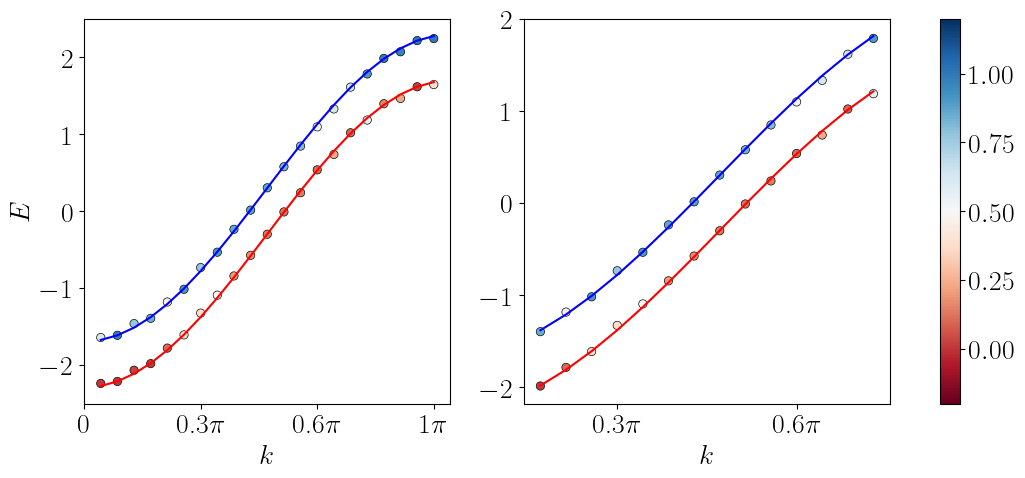

In [63]:
plot_2_bands(em0, ep0, proximity_m, proximity_p, pro_colors_m, pro_colors_p)

## First Order

here, both bands have the same correction. Notice how the perturbation is zero at some momenta namely **the perturbation is very small around $\pi/2$** and larger at the edges of the brillouin zone.

Text(0, 0.5, 'First Order Correction')

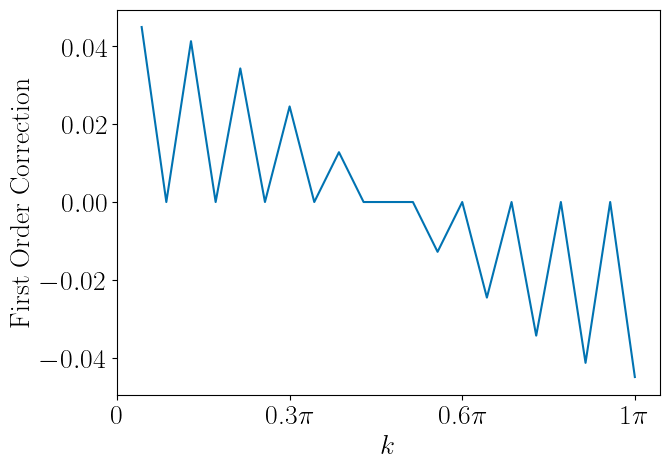

In [64]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# First order corrections
e1 = (1/(L_qpc+1))*np.sin(bond_index*k_single_band)*np.sin(bond_index*k_single_band+k_single_band)

plt.plot(k_single_band, e1)


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"First Order Correction")

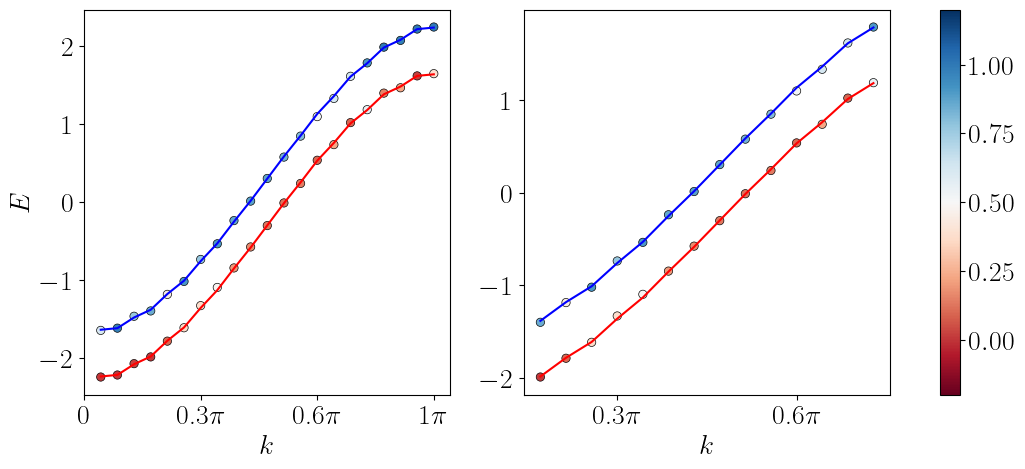

In [65]:
# first order corrections
Em = em0 + Omega*e1
Ep = ep0 + Omega*e1

plot_2_bands(Em, Ep, proximity_m, proximity_p, pro_colors_m, pro_colors_p)

Text(0, 0.5, '$Errors$')

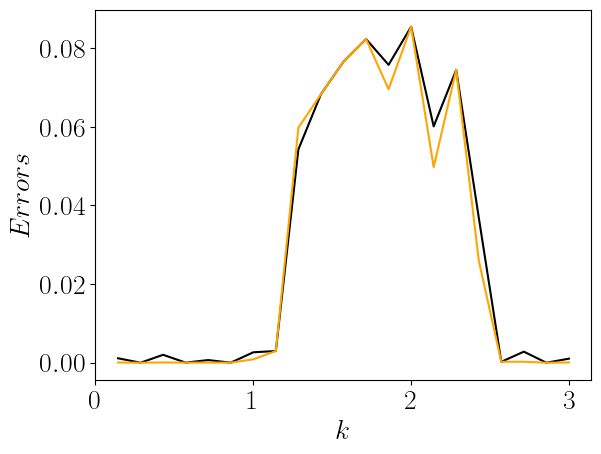

In [66]:
# plot the errors of the first correction vs zeroth order

Err0m = np.abs(energies_m - em0)**2
Err1m = np.abs(energies_m - Em)**2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")



## Second Order

Due to the normalization factor these corrections are super small nad the longer the chain the smaller they become

In [86]:
def xhi(K,P, B):
    return np.sin(B*P+P)*np.sin(B*K) + np.sin(B*K+K)*np.sin(B*P)

def get_second_order(krange, eta, Bond):
    # eta is +-t depemndeing on the qubit states
    E2 = []

    for k in krange:
        # remove k so te sums don't blow up
        p_range = np.asarray([x for x in krange if x != k])
        A_N = 1/(L_qpc+1)**2
    
        T1 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))) )
        T2 = A_N*(1/(2*eta))*xhi(k,k,bond_index)**2
        T3 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))+2*eta) )
    
        E2.append(T1 + T2 + T3) 
        
    E2 = np.asarray(E2)
    
    return E2
    

In [87]:
k_single_band[3]

0.5711986642890533

In [95]:
k=4*np.pi/22
A_N = 1/(L_qpc+1)**2
p_range = np.asarray([x for x in k_single_band if x != k])
A_N*np.sum( (xhi(k, p_range, bond_index)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range)))) 


3.55546629786982e-18

In [90]:
e2p_correction = get_second_order(k_single_band, t, bond_index)

e2m_correction = get_second_order(k_single_band, -t, bond_index)

(0.5, -0.5)

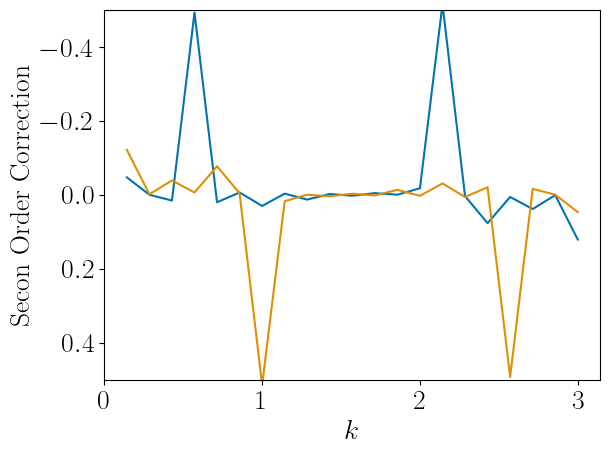

In [91]:
plt.plot(k_single_band, e2p_correction)
plt.plot(k_single_band, e2m_correction)


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"Secon Order Correction")
plt.ylim(0.5,-0.5)

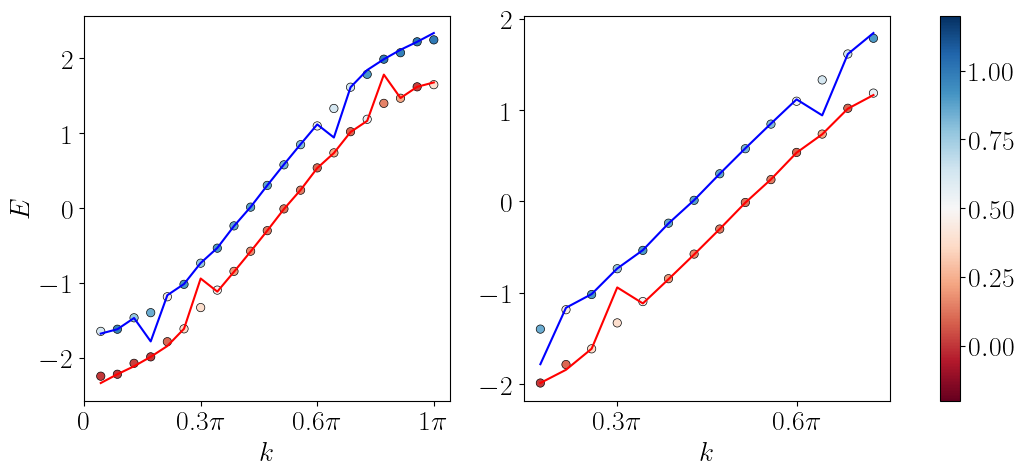

In [74]:
Ep2 = ep0 + Omega*e1 + (Omega**2)*e2p_correction
Em2 = em0 + Omega*e1 + (Omega**2)*e2m_correction

plot_2_bands(Em2, Ep2, proximity_m, proximity_p, pro_colors_m, pro_colors_p)

Text(0, 0.5, '$Errors$')

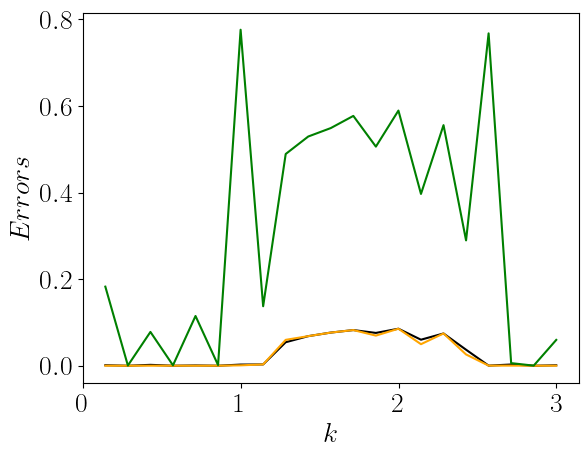

In [75]:
Err2m = np.abs(energies_m - Em2)*2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")
plt.plot(k_single_band,Err2m, c="green")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")

# Scattering and Spread

Comparing the numerics with our mathematics

In [19]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_full_df))
data_full_df.head()


Number of data points: 1398


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,bond_density_max,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,0.535270,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.543778,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.367979,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.541525,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.363672,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548


In [20]:
Deltax = 2.0
bindex = data_full_df["bond_index"].unique()[0]
vg_list = sorted(data_full_df.vg.unique())
k_list = sorted(data_full_df.k0.unique())
meff = 1/(2*J*np.cos(k_list))

tau_predict = np.sqrt(2*np.log(2))*0.5*Deltax**2*(1+(bindex/(vg_list*meff*Deltax**2))**2 )

tau_predict= np.sqrt(2*np.log(2))*(Deltax**2 + 0.5*((1/np.tan(k_list))*bindex/Deltax)**2)

ValueError: operands could not be broadcast together with shapes (100,) (7,) 

In [ ]:
curr_df = data_full_df[ (data_full_df["x_spread"]==2.0) ]
sns.scatterplot(curr_df, x="vg", y="time_at_bond")
plt.plot(vg_list, tau_predict)


# Looking at the pre measurement gained phase

In [ ]:
"res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

file_name = "res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity,\
                dd_costheta, dd_sinphi = load_data(data_route,file_name)
J=1

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


## Approximating the spread with the FWHM

# Ancilla